#Connect to google drive

In [1]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


#Install Packages

In [0]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # install python dependencies
  !pip install -q youtube-dl
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`

Selecting previously unselected package libgflags2.2.
(Reading database ... 144433 files and directories currently installed.)
Preparing to unpack .../00-libgflags2.2_2.2.1-1_amd64.deb ...
Unpacking libgflags2.2 (2.2.1-1) ...
Selecting previously unselected package libgflags-dev.
Preparing to unpack .../01-libgflags-dev_2.2.1-1_amd64.deb ...
Unpacking libgflags-dev (2.2.1-1) ...
Selecting previously unselected package libgoogle-glog0v5.
Preparing to unpack .../02-libgoogle-glog0v5_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog0v5 (0.3.5-1) ...
Selecting previously unselected package libgoogle-glog-dev.
Preparing to unpack .../03-libgoogle-glog-dev_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog-dev (0.3.5-1) ...
Selecting previously unselected package libhdf5-serial-dev.
Preparing to unpack .../04-libhdf5-serial-dev_1.10.0-patch1+docs-4_all.deb ...
Unpacking libhdf5-serial-dev (1.10.0-patch1+docs-4) ...
Selecting previously unselected package libleveldb1v5:amd64.
Preparing to unpack ...

#Extract landmarks and turn to csv (DELETE)

In [0]:
%%shell
mkdir '/content/drive/My Drive/csv/'
mkdir '/content/drive/My Drive/json/'
mkdir '/content/drive/My Drive/test_video/'
for YOUTUBE_ID in 'EsxSxC09KUU' 'qNXn_kW6WtA' 'jnGqAN6YOZ0' 'PD8IWT3oa5s' 't1u9_DHs4r4' 'l3tnBOQG4zU' 'uTbEdPzsXGo' '0mc6IJd0NEw' 'LqRJSNM814g' 'IS3YZ9JSsnc' 'UUtdMuT1EBU' 'NEkWx0pmzq4'
{
    youtube-dl -f 'bestvideo[ext=mp4]' --output "/content/drive/My Drive/test_video/${YOUTUBE_ID}.%(ext)s" https://www.youtube.com/watch?v=$YOUTUBE_ID
}

In [0]:
%%shell
cd /content/openpose
for entry in `ls ../drive/My\ Drive/test_video/`; do
  first=${entry:0:11}
  echo ${first}
  ./build/examples/openpose/openpose.bin --video ../drive/My\ Drive/test_video/$entry --write_json ../drive/My\ Drive/json/${first} --write_video ../drive/My\ Drive/csv/$entry --display 0 --number_people_max 1 --keypoint_scale 3 --face --hand
done

In [0]:
import json
import pandas as pd
import numpy as np
import os, os.path
import time
import csv

N_FACE = 70
N_POSE = 25
N_HAND = 21
COL_NAMES = ['vid', 'frame']
COL_NAMES += ['f_' + str(i) for i in range(N_FACE * 2)]
COL_NAMES += ['p_' + str(i) for i in range(N_POSE * 2)]
COL_NAMES += ['lh_' + str(i) for i in range(N_HAND * 2)]
COL_NAMES += ['rh_' + str(i) for i in range(N_HAND * 2)]

droplist_f = set([(i * 3 + 2) for i in range(N_FACE)])
droplist_p = set([(i * 3 + 2) for i in range(N_POSE)])
droplist_h = set([(i * 3 + 2) for i in range(N_HAND)])
idx_f = [i for i in range(N_FACE * 3) if (i not in droplist_f)]
idx_p = [i for i in range(N_POSE * 3) if (i not in droplist_p)]
idx_h = [i for i in range(N_HAND * 3) if (i not in droplist_h)]

url = ['EsxSxC09KUU', 'qNXn_kW6WtA', 'jnGqAN6YOZ0', 'PD8IWT3oa5s', 't1u9_DHs4r4', 'l3tnBOQG4zU', 'uTbEdPzsXGo', '0mc6IJd0NEw', 'LqRJSNM814g', 'IS3YZ9JSsnc', 'UUtdMuT1EBU', 'NEkWx0pmzq4']
names = ['1200_2', '1300_2', '1400_1', '1500_1', '1600_1', '1600_2', '1600_3', '1600_4', '1700_2', '1800_2', '1900_2', '2000_2']
name_dict = dict(zip(url, names))

CSV_FOLDER = '/content/drive/My Drive/csv/'
JSON_FOLDER = '/content/drive/My Drive/json/'
VIDEO_FOLDER = '/content/drive/My Drive/video/'

In [0]:
for i in name_dict:
  print('mv {}.mp4 {}.mp4'.format(i, name_dict[i]))

mv EsxSxC09KUU.mp4 1200_2.mp4
mv qNXn_kW6WtA.mp4 1300_2.mp4
mv jnGqAN6YOZ0.mp4 1400_1.mp4
mv PD8IWT3oa5s.mp4 1500_1.mp4
mv t1u9_DHs4r4.mp4 1600_1.mp4
mv l3tnBOQG4zU.mp4 1600_2.mp4
mv uTbEdPzsXGo.mp4 1600_3.mp4
mv 0mc6IJd0NEw.mp4 1600_4.mp4
mv LqRJSNM814g.mp4 1700_2.mp4
mv IS3YZ9JSsnc.mp4 1800_2.mp4
mv UUtdMuT1EBU.mp4 1900_2.mp4
mv NEkWx0pmzq4.mp4 2000_2.mp4


In [0]:
%%shell
cd '/content/drive/My Drive/video/'
mv EsxSxC09KUU.mp4 1200_2.mp4
mv qNXn_kW6WtA.mp4 1300_2.mp4
mv jnGqAN6YOZ0.mp4 1400_1.mp4
mv PD8IWT3oa5s.mp4 1500_1.mp4
mv t1u9_DHs4r4.mp4 1600_1.mp4
mv l3tnBOQG4zU.mp4 1600_2.mp4
mv uTbEdPzsXGo.mp4 1600_3.mp4
mv 0mc6IJd0NEw.mp4 1600_4.mp4
mv LqRJSNM814g.mp4 1700_2.mp4
mv IS3YZ9JSsnc.mp4 1800_2.mp4
mv UUtdMuT1EBU.mp4 1900_2.mp4
mv NEkWx0pmzq4.mp4 2000_2.mp4

In [0]:
%%shell
cd '/content/drive/My Drive/test_video/'
mv EsxSxC09KUU.mp4 1200_2.mp4
mv qNXn_kW6WtA.mp4 1300_2.mp4
mv jnGqAN6YOZ0.mp4 1400_1.mp4
mv PD8IWT3oa5s.mp4 1500_1.mp4
mv t1u9_DHs4r4.mp4 1600_1.mp4
mv l3tnBOQG4zU.mp4 1600_2.mp4
mv uTbEdPzsXGo.mp4 1600_3.mp4
mv 0mc6IJd0NEw.mp4 1600_4.mp4
mv LqRJSNM814g.mp4 1700_2.mp4
mv IS3YZ9JSsnc.mp4 1800_2.mp4
mv UUtdMuT1EBU.mp4 1900_2.mp4
mv NEkWx0pmzq4.mp4 2000_2.mp4

In [0]:
# collect the json output of openpose and combine them into csv
def json_to_csv(folderpath, csv_path, vid, csv_writer):
  cnt = 0
  for name in sorted(os.listdir(folderpath)): 
    if name[-4:] == 'json':
      filepath = os.path.join(folderpath, name)   
      if os.path.isfile(filepath):
        with open(filepath, 'r') as f:
          data = json.load(f)['people']
          
          if len(data) > 0:
            row = [vid, int(name[12:-15])]
            row_face = [float(data[0]['face_keypoints_2d'][j]) for j in idx_f]
            row_pose = [float(data[0]['pose_keypoints_2d'][j]) for j in idx_p]
            row_lh = [float(data[0]['hand_left_keypoints_2d'][j]) for j in idx_h]
            row_rh = [float(data[0]['hand_right_keypoints_2d'][j]) for j in idx_h]           
          else:
            row = [vid, int(name[12:-15])]
            row_face = [float(0) for j in idx_f]
            row_pose = [float(0) for j in idx_p]
            row_lh = [float(0) for j in idx_h]
            row_rh = [float(0) for j in idx_h]
          
          row += row_face + row_pose + row_lh + row_rh            
          row = np.array(row)
          csv_writer.writerow(row)
          cnt += 1
  print(vid, cnt)


for folder in sorted(os.listdir(JSON_FOLDER)):
  csv_path = CSV_FOLDER + name_dict[folder] + '.csv'
  write_file = open(csv_path, 'w')
  csv_writer = csv.writer(write_file) 
  csv_writer.writerow(COL_NAMES)
  folderpath = os.path.join(JSON_FOLDER, folder)
  json_to_csv(folderpath, csv_path, name_dict[folder], csv_writer)

#Functions 

In [2]:
!pip install opencv-python

Input your own json folder path and your label csv file path here to './drive/My Drive/636/test/'

In [0]:
import json
import pandas as pd
import numpy as np
import os, os.path
import csv
import cv2

N_FACE = 70
N_POSE = 25
N_HAND = 21
N_FEATURES = N_POSE * 2
# N_FEATURES = (N_FACE + N_POSE + N_HAND * 2) * 2

# FOLDER = '/content/drive/My Drive/636/test/fig/'
FOLDER = '/content/drive/My Drive/fig/'
CSV_FOLDER = '/content/drive/My Drive/636/test/'
MODEL_FOLDER = '/content/drive/My Drive/636/model/'
JSON_FOLDER = '/content/drive/My Drive/636/test/op_json'
COL_NAMES = ['frame']
# COL_NAMES += ['f_' + str(i) for i in range(N_FACE * 2)]
COL_NAMES += ['p_' + str(i) for i in range(N_POSE * 2)]
# COL_NAMES += ['lh_' + str(i) for i in range(N_HAND * 2)]
# COL_NAMES += ['rh_' + str(i) for i in range(N_HAND * 2)]

# droplist_f = set([(i * 3 + 2) for i in range(N_FACE)])
droplist_p = set([(i * 3 + 2) for i in range(N_POSE)])
# droplist_h = set([(i * 3 + 2) for i in range(N_HAND)])
# idx_f = [i for i in range(N_FACE * 3) if (i not in droplist_f)]
idx_p = [i for i in range(N_POSE * 3) if (i not in droplist_p)]
# idx_h = [i for i in range(N_HAND * 3) if (i not in droplist_h)]

In [0]:
# collect the json output of openpose and combine them into csv
def json_to_csv(folderpath, csv_path):
  idx = 0
  write_file = open(csv_path, 'w')
  csv_writer = csv.writer(write_file)
  csv_writer.writerow(COL_NAMES)
  for name in sorted(os.listdir(folderpath)): 
    if name[-4:] == 'json':
      filepath = os.path.join(folderpath, name)
      if os.path.isfile(filepath):
        with open(filepath, 'r') as f:
          data = json.load(f)['people']
          if len(data) > 0:
            row = [name] + [float(data[0]['pose_keypoints_2d'][j]) for j in idx_p]
            # row = [name]
            # row_face = [float(data[0]['face_keypoints_2d'][j]) for j in idx_f]
            # row_pose = [float(data[0]['pose_keypoints_2d'][j]) for j in idx_p]
            # row += row_face + row_pose
            row = np.array(row)
            csv_writer.writerow(row)
      idx += 1

def get_csv(name):
  csv_path = FOLDER + name + '.csv'
  json_to_csv(JSON_FOLDER, csv_path)

In [0]:
# # Reshape Data into Segments and Prepare for Keras
# # slice every TIME_STEP frame as a segment until from 1st frame to last, if null, make up with 0
# def get_slices(df, TIME_STEP, fps):
#   slices = []
#   ts = []
#   df = df[df.columns[1:51]]
#   for i in range(df.shape[0]):
#     ts.append(i/fps)
#     if i + 1 < TIME_STEP:
#       slice_ = df.values[df.index[0 : i + 1]]
#       fillzero = np.zeros((TIME_STEP - i - 1, N_FEATURES))
#       slice_ = np.concatenate((fillzero, slice_), axis=0)
#       slices.append(slice_)
#     else:
#       slices.append(df.values[df.index[i + 1 - TIME_STEP : i + 1]])

#   slices_arr = np.asarray(slices, dtype= np.float32)
#   ts_arr = np.asarray(ts, dtype= np.float32)
#   return slices_arr, ts_arr

In [0]:
# Reshape Data into Segments and Prepare for Keras
# slice every TIME_STEP frame as a segment until from 1st frame to last, if null, make up with 0
def get_slices(df, TIME_STEP, cols, fps):
  slices = []
  ts = []
  df = df[cols]
  for i in range(df.shape[0]):
    ts.append(i/fps)
    if i + 1 < TIME_STEP:
      continue
    else:
      slices.append(df.values[df.index[i + 1 - TIME_STEP : i + 1]])

  slices_arr = np.asarray(slices, dtype= np.float32)
  ts_arr = np.asarray(ts[TIME_STEP - 1:], dtype= np.float32)
  return slices_arr, ts_arr

In [0]:
# Draw figure
import matplotlib.pyplot as plt
from google.colab import files

def drawplt(time, pred, name):
  plt.figure(figsize=(10,8))
  plt.plot(time, pred, 'b', label='prediction', markersize=3, color='red')
  plt.title('Prediction over time')
  my_y_ticks = np.arange(0, 1.1, 0.1)
  plt.yticks(my_y_ticks)
  plt.legend()
  plt.savefig(name)

In [0]:
# Generate json
def to_json(name, ts_arr, y_pred):
  np_pred = np.array((ts_arr, y_pred.flatten())).T
  pred_list = np_pred.tolist()
  pred_dict = {"cry":pred_list}
  pred_json = json.dumps(pred_dict)
  with open(name, 'w') as json_file:
    json_file.write(pred_json)

In [0]:
%tensorflow_version 1.x
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, LSTM, Dropout, Flatten, Conv1D, Activation, MaxPooling1D, Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import History, EarlyStopping, ModelCheckpoint
from keras.models import load_model

TensorFlow 1.x selected.


Using TensorFlow backend.


#Download test video and get input matrix

In [0]:
!rm video.mp4
!youtube-dl -f 'bestvideo[ext=mp4]' --output "video.%(ext)s" https://www.youtube.com/watch?v=$YOUTUBE_ID

[youtube] t1u9_DHs4r4: Downloading webpage
[download] Destination: video.mp4
[download] 100% of 764.51KiB in 00:00


In [0]:
# def show_local_mp4_video(file_name, width=640, height=480):
#   import io
#   import base64
#   from IPython.display import HTML
#   video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
#   return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
#                         <source src="data:video/mp4;base64,{2}" type="video/mp4" />
#                       </video>'''.format(width, height, video_encoded.decode('ascii')))

# show_local_mp4_video('video.mp4', width=960, height=720)

#OpenPose

In [0]:
# Generate facial landmarks
%%shell
rm -r /content/drive/My\ Drive/636/test/op_json/*
cd openpose
./build/examples/openpose/openpose.bin --video /content/video.mp4 --write_json /content/drive/My\ Drive/636/test/op_json --render_pose 0 --number_people_max 1 --keypoint_scale 3 --display 0

Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 19.106717 seconds.


In [0]:
get_csv(NAME)

#Prediction

In [0]:
VIDEO_FOLDER + url + '.mp4'

'/content/drive/My Drive/csv/video/uTbEdPzsXGo.mp4'

In [0]:
names = ['1200_2', '1300_2', '1400_1', '1500_1', '1600_1', '1600_2', '1600_3', '1600_4', '1700_2', '1800_2', '1900_2', '2000_2']

In [0]:
def get_pred(url, name, model, time_step):
  X = pd.read_csv(CSV_FOLDER + name + '.csv')
  # Get fps
  videoCapture = cv2.VideoCapture(VIDEO_FOLDER + url + '.mp4')
  fps = videoCapture.get(cv2.CAP_PROP_FPS)
  # print(fps)
  # get input and time array
  cols = ['p_' + str(i) for i in range(N_POSE * 2)]
  X_arr, ts_arr = get_slices(X, time_step, cols, fps)
  print(X_arr.shape, ts_arr.shape)
  # get prediction
  y_pred = model.predict(X_arr)
  # draw plot
  fig_name = FOLDER + name + '.png'
  drawplt(ts_arr, y_pred, fig_name)
  # output json file
  js_name = FOLDER + name + '.json'
  to_json(js_name, ts_arr, y_pred)

(446, 15, 50) (446,)
(256, 15, 50) (256,)
(224, 15, 50) (224,)
(274, 15, 50) (274,)
(243, 15, 50) (243,)
(205, 15, 50) (205,)
(345, 15, 50) (345,)
(346, 15, 50) (346,)
(516, 15, 50) (516,)
(459, 15, 50) (459,)
(146, 15, 50) (146,)
(228, 15, 50) (228,)


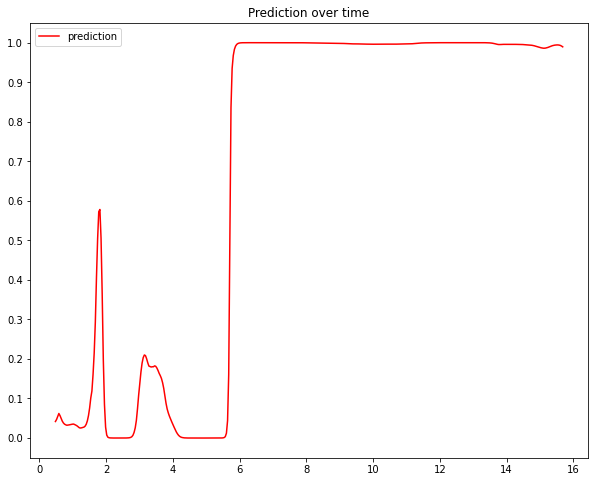

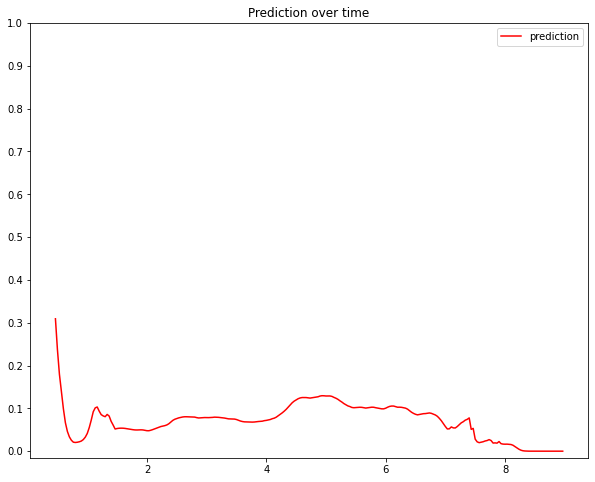

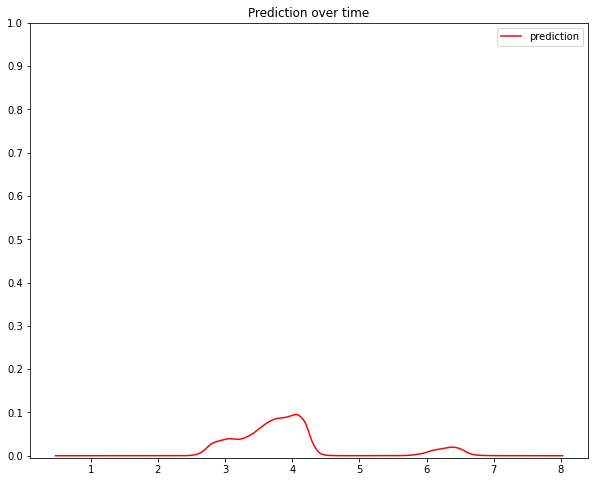

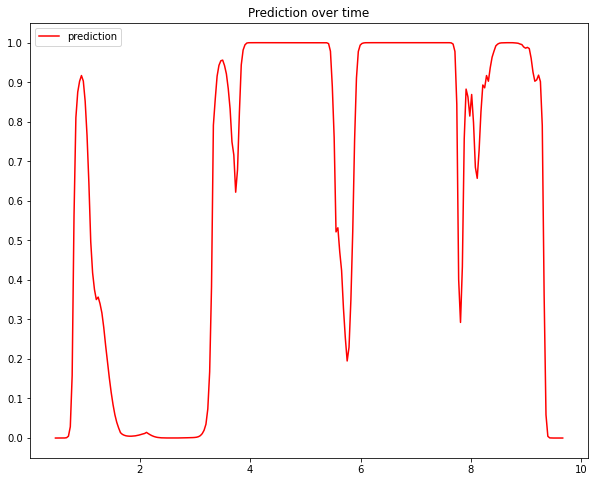

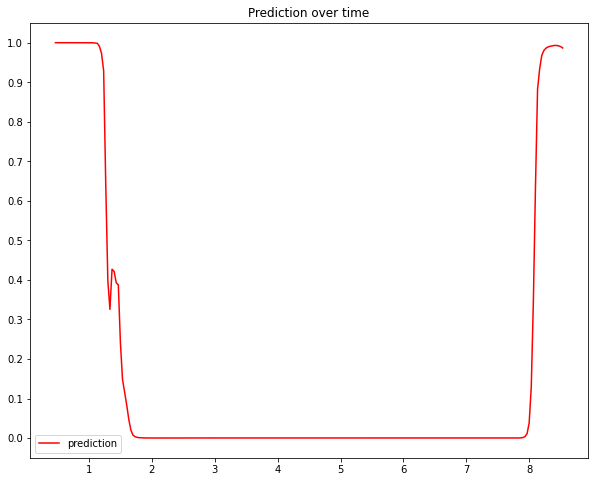

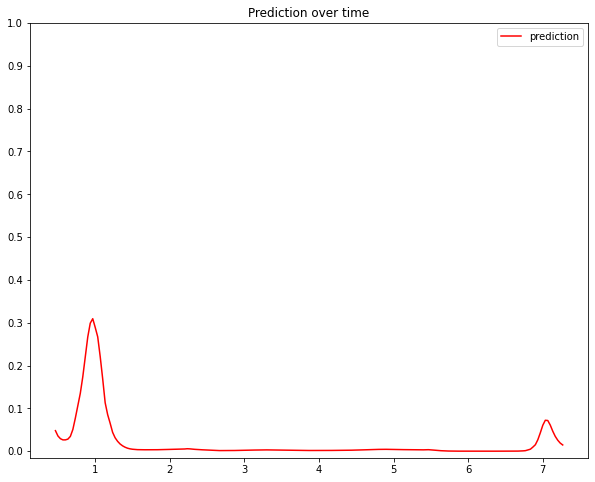

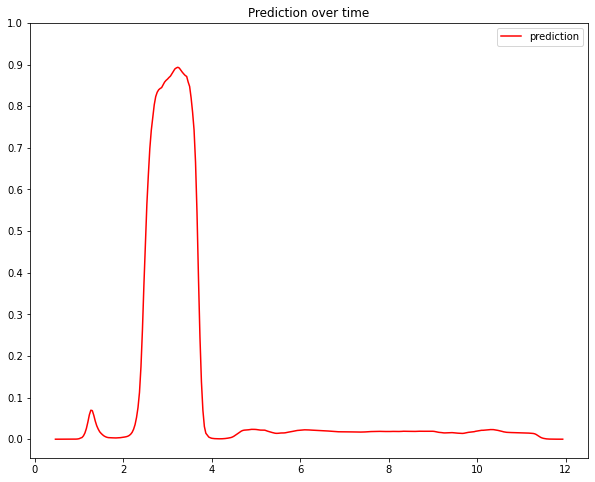

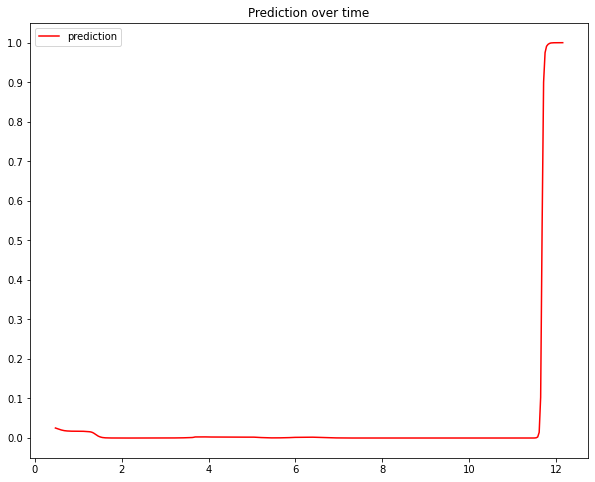

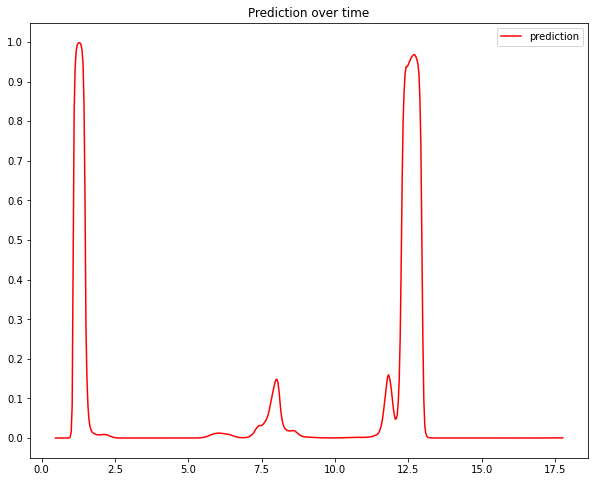

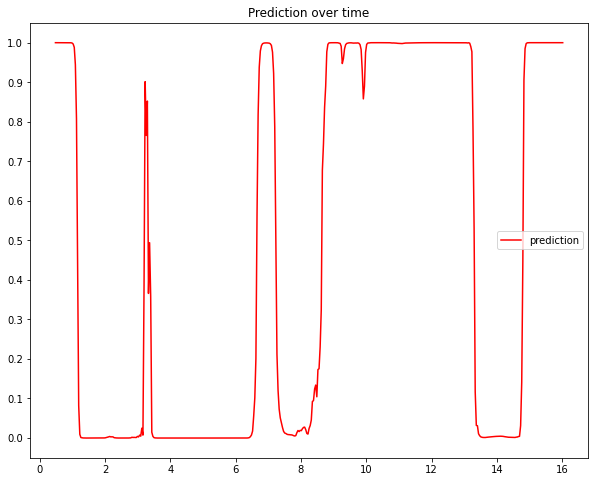

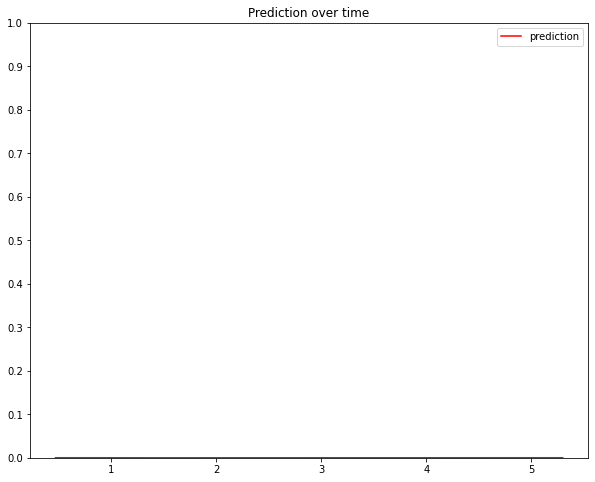

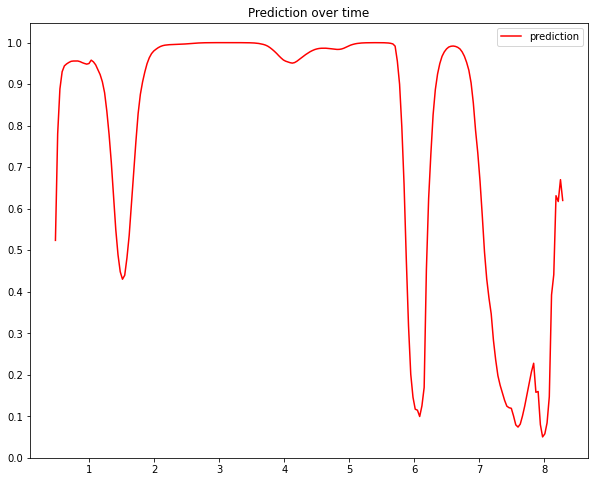

In [0]:
model = load_model(MODEL_FOLDER + 'model1_15_8603.h5')
for url in name_dict:
  name = name_dict[url]
  get_pred(url, name, model, 15)

(441, 20, 50) (441,)
(251, 20, 50) (251,)
(219, 20, 50) (219,)
(269, 20, 50) (269,)
(238, 20, 50) (238,)
(200, 20, 50) (200,)
(340, 20, 50) (340,)
(341, 20, 50) (341,)
(511, 20, 50) (511,)
(454, 20, 50) (454,)
(141, 20, 50) (141,)
(223, 20, 50) (223,)


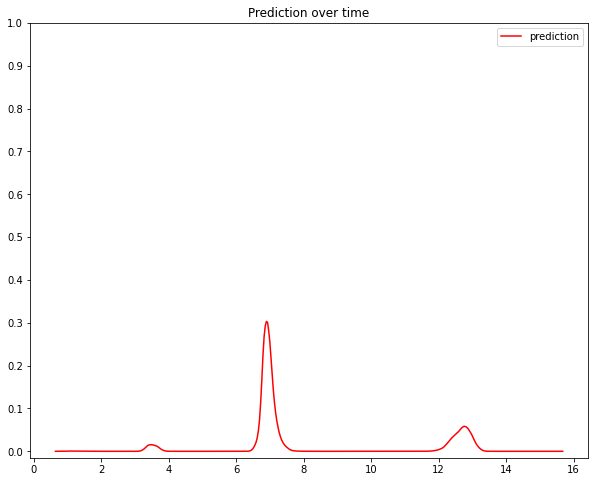

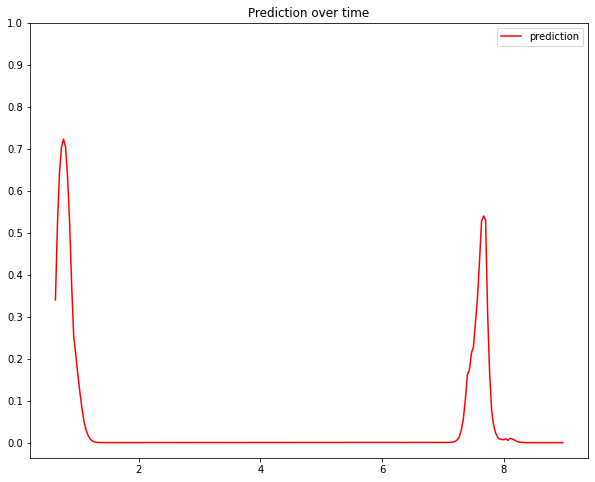

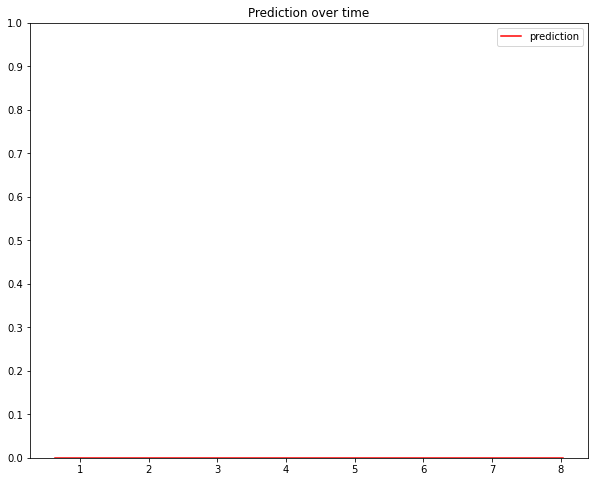

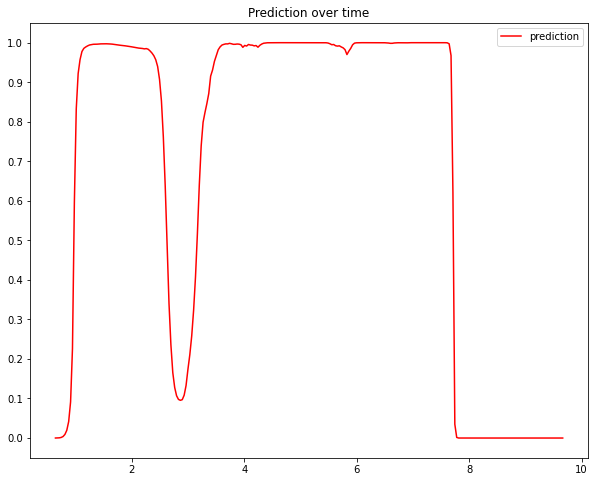

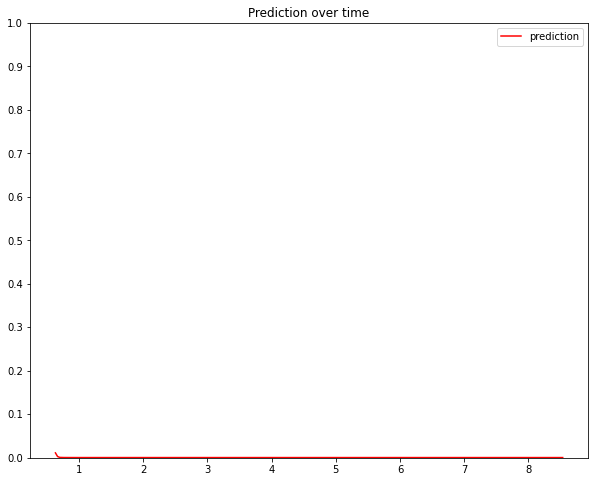

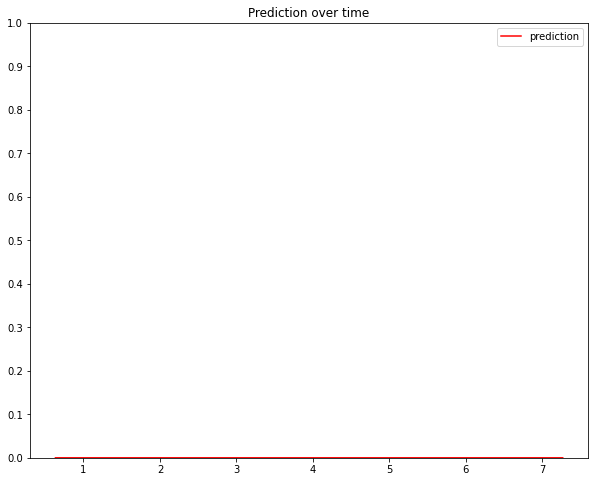

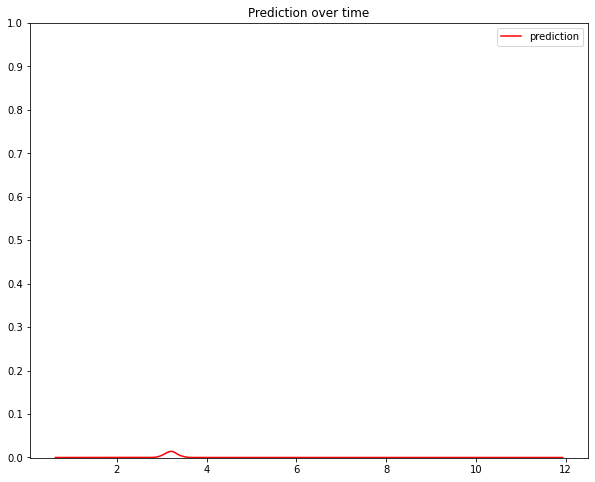

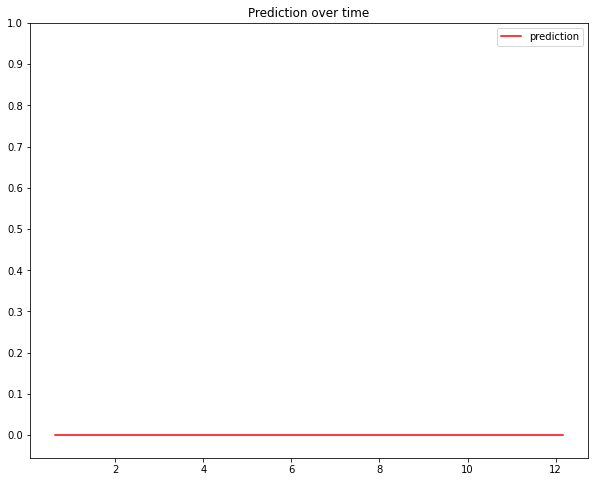

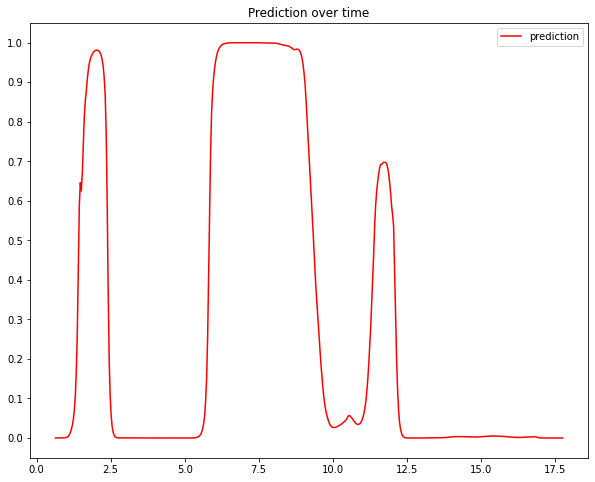

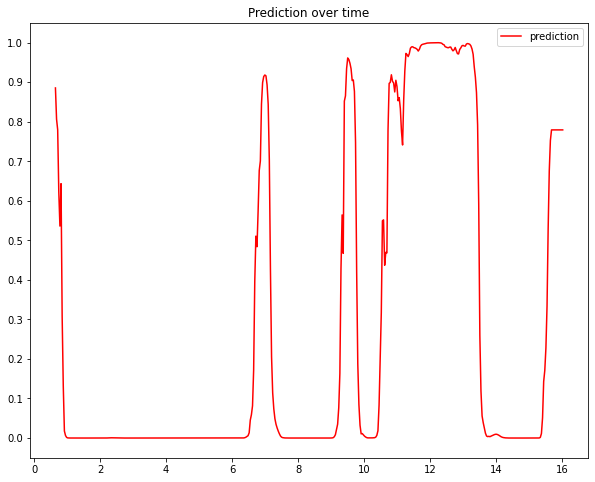

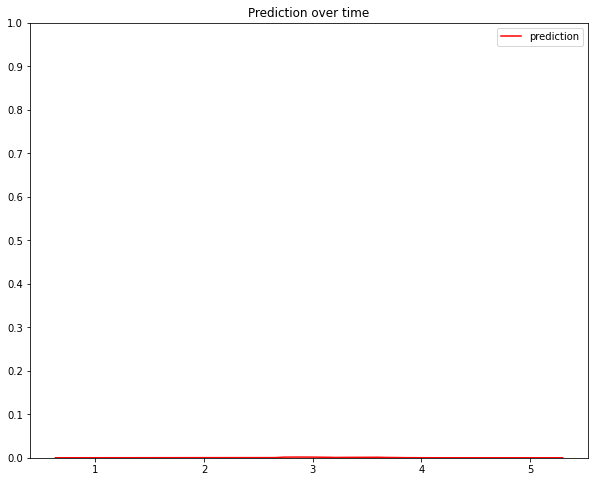

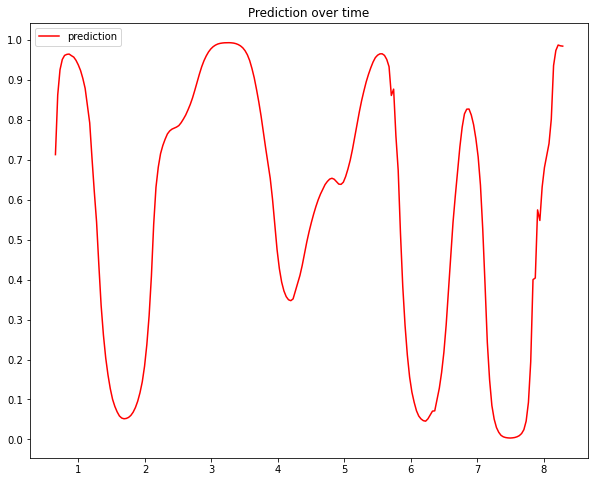

In [0]:
model = load_model(MODEL_FOLDER + 'model1_20_8633.h5')
for url in name_dict:
  name = name_dict[url]
  get_pred(url, name, model, 20)